Used for test SHAP value: based on the selected ASVs, most of which are indicators of Non burn soil (which means if it has a higher abundance then it is a not burn soil; these ASV will decrease if it get burned); the only ASV we found will increase if get burned is ASV7.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-03-06 15:34:19.148156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 15:34:19.151292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:34:19.154602: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 15:34:19.164763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741293259.182694  596663 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741293259.18

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

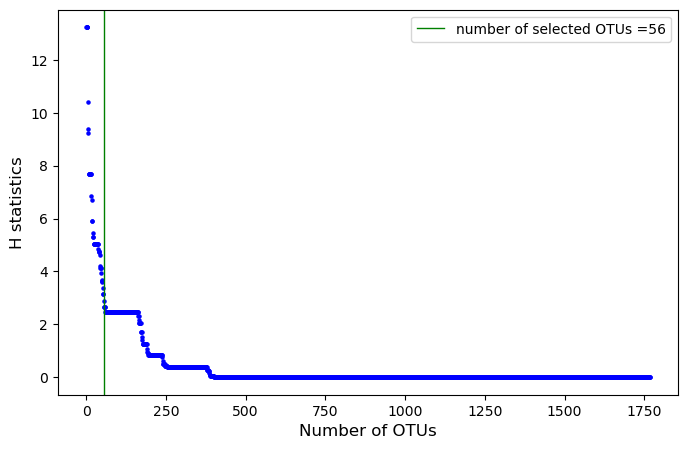

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,burn_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [9]:

targetLabel=burn_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list


The response variable and its counts are:
Burn
Yes    42
No     17
Name: count, dtype: int64


In [10]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))


The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(targetLabel)  

In [46]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X_FS,columns=selectedASV_list), y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_jobs=5, random_state=777)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
y_prob1 = y_prob[:, 1]




In [47]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
mcc = metric.mcc_score(y_test,y_pred)
f_score = f1_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob1)



explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)


In [40]:
print(accuracy)

0.8333333333333334


In [51]:
print(pd.DataFrame(shap_obj.data, columns=shap_obj.feature_names, index=X_test.index))

    ASV66     ASV81     ASV85    ASV141    ASV148     ASV43     ASV73  \
0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5     0.0  0.000000  0.000000  0.000000  0.000000  0.013375  0.000000   
34    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
45    0.0  0.000000  0.013508  0.018263  0.000000  0.038634  0.000000   
53    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
57    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
47    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
49    0.0  0.011778  0.000000  0.011154  0.010797  0.000000  0.061123   
3     0.0  0.000000  0.000000  0.000000  0.000000  0.061344  0.000000   

       ASV38    ASV139    ASV154  ...    ASV231   

<Figure size 1000x800 with 0 Axes>

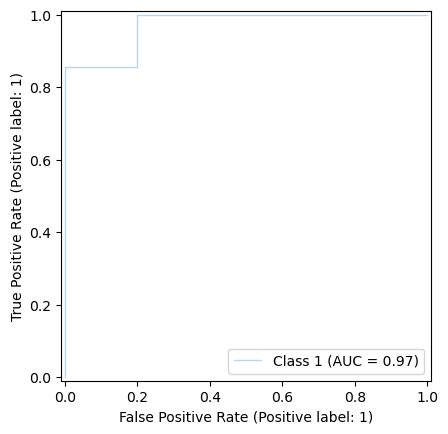

In [48]:
import matplotlib.pyplot as plt
# Plot the ROC curve for each class using RocCurveDisplay
plt.figure(figsize=(10, 8))

# Loop through each class to plot the ROC curve
RocCurveDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        name=f"Class {1}",
        alpha=0.3,
        lw=1)


In [49]:
high_index = pd.DataFrame(shap_obj.data, columns=shap_obj.feature_names, index=X_test.index).idxmax()# finds the feature with the highest value for each sample.
high_index



ASV66      0
ASV81     49
ASV85     45
ASV141    45
ASV148    49
ASV43      3
ASV73     49
ASV38     57
ASV139    49
ASV154     0
ASV174    49
ASV181    49
ASV208     0
ASV216     0
ASV263    49
ASV272    49
ASV94     49
ASV7      25
ASV3      13
ASV19     34
ASV45      3
ASV11     25
ASV24     34
ASV91     49
ASV133     5
ASV146     0
ASV150     0
ASV159     0
ASV191    45
ASV207     0
ASV225     0
ASV274    45
ASV315     5
ASV335    49
ASV338     0
ASV348     0
ASV369    49
ASV384     0
ASV51      3
ASV5      45
ASV13     25
ASV18     12
ASV2      34
ASV30     25
ASV104    57
ASV183    57
ASV231    57
ASV27     25
ASV8       3
ASV15     25
ASV26     12
ASV1      13
ASV79     49
ASV54     25
ASV59     25
ASV32      5
dtype: int64

In [55]:
shap_1 = pd.DataFrame(shap_values[:,:,1], columns=shap_obj.feature_names, index=X_test.index)

In [56]:
print(shap_1)

       ASV66     ASV81     ASV85    ASV141    ASV148     ASV43     ASV73  \
0   0.014250  0.008187  0.007461  0.006271  0.011859  0.002757  0.008263   
5   0.010709  0.005420  0.004571  0.002951  0.007535 -0.061452  0.006403   
34  0.014487  0.008186  0.007274  0.005904  0.010972  0.002548  0.007443   
13  0.014694  0.008565  0.007686  0.006460  0.011578  0.003191  0.008918   
45  0.012186  0.005202 -0.012441 -0.072299  0.008132 -0.046439  0.005366   
53  0.015581  0.008900  0.008476  0.006365  0.012486  0.003127  0.010600   
57  0.012768  0.006393  0.005152  0.003907  0.010412  0.001789  0.010409   
25  0.014744  0.008471  0.007740  0.006434  0.011603  0.002969  0.008600   
47  0.014703  0.008596  0.007723  0.006444  0.011297  0.002942  0.008567   
12  0.014935  0.008434  0.007712  0.006395  0.011790  0.002886  0.009219   
49  0.015074  0.008173  0.005266 -0.078876 -0.059132  0.001734 -0.071180   
3   0.009445  0.005650  0.004963  0.003247  0.007911 -0.060441  0.004644   

       ASV3

In [58]:
enriched = list()
for v, i in high_index.items():
    sv = shap_1[v].loc[i]
    if sv<0:
        sv = "Level 0"
    else:
        sv = "Level 1"
    enriched.append(
        {
            'Taxa': v,
            'enriched': sv
        }
    )
enriched = pd.DataFrame(enriched)
enriched.rename(columns={'enriched': 'enriched{}'.format(2)}, inplace=True)

In [59]:
enriched

,Taxa,enriched2
0,ASV66,Level 1
1,ASV81,Level 1
2,ASV85,Level 0
3,ASV141,Level 0
4,ASV148,Level 0
5,ASV43,Level 0
6,ASV73,Level 0
7,ASV38,Level 0
8,ASV139,Level 0
9,ASV154,Level 0
